In [2]:
import time, os, json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib as mpl
from operator import is_not
from functools import partial
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [3]:
def regressionLoss(y_pred, y_true, metric = 'RAE', outlier_filter = False, outlier_thres = 20):
    metric = metric.lower()
    if outlier_filter:
        std = regressionLoss(y_pred, y_true, 'RMSE', False)
        outlier_flag = (np.abs(y_pred - y_true) > std*outlier_thres)
        num_outlier = np.sum(outlier_flag)
        return regressionLoss(y_pred[~outlier_flag], y_true[~outlier_flag], metric, False), num_outlier

    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_mean = y_true.mean()
    if metric == 'rae':
        return sum(abs(y_pred - y_true)) / sum(abs(y_mean - y_true))
    elif metric == 'rse':
        return sum((y_pred - y_true)**2) / sum((y_mean - y_true)**2)
    elif metric == 'rmse':
        return ((y_pred - y_true)**2).mean()**.5
    elif metric == 'r square':
        sst = sum((y_true - y_mean) ** 2)
        ssr = sum((y_true - y_pred) ** 2)
        return 1 - ssr/sst

In [4]:
for file in os.listdir('data'):
    if file.endswith('all.json'):
        print(file)

FileNotFoundError: [Errno 2] No such file or directory: 'data'

KeyError: 'gptj_grid_y'

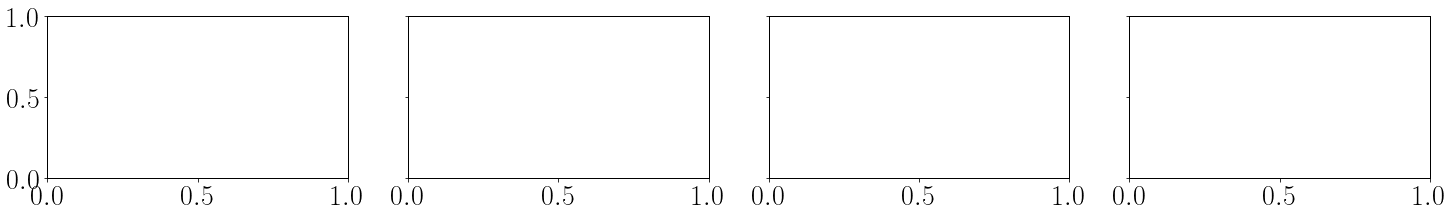

In [13]:
lbd_list = [0, 10, 50, 100]

file_list = {}
        
width = 20
height = 3

plt.rc('font', family='serif', serif='times new roman')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=28)
plt.rc('ytick', labelsize=28)
plt.rc('axes', labelsize=28)
plt.rc('axes', linewidth=1)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

####
markers = ['o', '*', '<']

fig, ax = plt.subplots(nrows=1, ncols=len(lbd_list), sharex=True, sharey=True) #plot two subgraphs in one figure, 1 by 2 size, sharing y-axis
fig.subplots_adjust(left=.03, bottom=.15, right=0.99, top=0.9, wspace=0.2) #margin of the figure
fig.set_size_inches(width, height) #exact size of the figure

for i in range(len(lbd_list)):
    lbd = lbd_list[i]
    with open('data_1/linear_lbd_%d_n_250_p_1_int_0_(-10.0,10.0)_noise_0.00_all.json' % lbd, 'r') as f:
        data_json = json.load(f)
    grid_x = np.array(data_json['grid_x'])
    gpt3 = np.array(data_json['gpt3_grid_y'])
    gptj = np.array(data_json['gptj_grid_y'])
    invalid_idx = gpt3 == None
    valid_gpt3 = gpt3[~invalid_idx]
    
    X_train = data_json['train_x']
    y_train = data_json['train_y']
    lm = LinearRegression()
    lm.fit(X_train, y_train)
    grid_y = lm.predict(grid_x)
    
    ax[i].plot(grid_x[~invalid_idx], valid_gpt3, label = 'LIFT/GPT-3')
    ax[i].plot(grid_x,gptj, label = 'LIFT/GPT-J')
    rae = regressionLoss(valid_gpt3, grid_y)
    ax[i].set_title(r'$\lambda=$%d, RAE = %.3f' % (lbd,rae), fontsize = 20)
    lm = LinearRegression()
    lm.fit(X_train, y_train)
    grid_y = lm.predict(grid_x)
    ax[i].plot(grid_x, grid_y, label = 'Ridge')
ax[0].legend(fontsize = 15)
plt.savefig(os.path.join('ridge_vis.pdf'))
None

In [10]:
lbd_list = [0,10,50,100, 1000]
p_list = [1, 10, 50] 
width = 45

print("-" * width)
print("| p |lambda|    RAE LR      |    RAE Ridge   |")
print("-" * width)

rae_ridge_gpt3, rae_ridge_gptj = {}, {}
rae_lr_gpt3, rae_lr_gptj = {}, {}
for sim_idx in range(1,4):
    for p in p_list:
        for i in range(len(lbd_list)):
            if not (p,i) in rae_ridge_gpt3:
                rae_ridge_gpt3[p,i], rae_lr_gpt3[p,i] = [], []
                rae_ridge_gptj[p,i], rae_lr_gptj[p,i] = [], []
            lbd = lbd_list[i]
            with open('data_3/linear_lbd_%d_n_250_p_%d_int_0_(-10.0,10.0)_noise_0.00_all.json' % (lbd, p), 'r') as f:
                data_json = json.load(f)
            grid_x = np.array(data_json['test_x'])
            gpt3 = np.array(data_json['gpt3_test_y'])
            gptj = np.array(data_json['gptj_test_y'])
            invalid_idx = gpt3 == None
            # print(invalid_idx.sum())
            valid_gpt3 = gpt3[~invalid_idx]

            X_train = data_json['train_x']
            y_train = data_json['train_y']
            lm = LinearRegression()
            lm.fit(X_train, y_train)
            grid_y = lm.predict(grid_x)

            lm = LinearRegression()
            lm.fit(X_train, y_train)
            grid_y = lm.predict(grid_x)

            rae_ridge_gpt3[p,i].append(regressionLoss(valid_gpt3, grid_y))
            rae_lr_gpt3[p,i].append(regressionLoss(valid_gpt3, np.array(data_json['test_y'])))
            
            rae_ridge_gptj[p,i].append(regressionLoss(gptj, grid_y))
            rae_lr_gptj[p,i].append(regressionLoss(gptj, np.array(data_json['test_y'])))
            
for p in p_list:
    for i in range(len(lbd_list)):
        lbd = lbd_list[i]
        m_ridge_gpt3, s_ridge_gpt3 = np.mean(rae_ridge_gpt3[p,i]), np.std(rae_ridge_gpt3[p,i])
        m_lr_gpt3, s_lr_gpt3 = np.mean(rae_lr_gpt3[p,i]), np.std(rae_lr_gpt3[p,i])
        
        m_ridge_gptj, s_ridge_gptj = np.mean(rae_ridge_gptj[p,i]), np.std(rae_ridge_gptj[p,i])
        m_lr_gptj, s_lr_gptj = np.mean(rae_lr_gptj[p,i]), np.std(rae_lr_gptj[p,i])
        print(r'%d%s & %d%s & %.3f $\pm$ %.3f%s& %.3f $\pm$ %.3f%s &  %.3f$\pm$%.3f%s & %.3f$\pm$%.3f%s \\' % (p,' '*(3-len(str(p))),lbd,' '*(6-len(str(lbd))),m_lr_gptj,s_lr_gptj, ' '*(9-len(str(round(m_lr_gptj)))),m_ridge_gptj,s_ridge_gptj, ' '*(9-len(str(round(m_ridge_gptj)))),m_lr,s_lr, ' '*(9-len(str(round(m_lr)))), m_ridge_gpt3,s_ridge_gpt3, ' '*(9-len(str(round(m_ridge_gpt3))))))
    print('\midrule')

---------------------------------------------
| p |lambda|    RAE LR      |    RAE Ridge   |
---------------------------------------------
1   & 0      & 0.000 $\pm$ 0.000        & 0.000 $\pm$ 0.000         &  0.915$\pm$0.000         & 0.000$\pm$0.000         \\
1   & 10     & 0.000 $\pm$ 0.000        & 0.016 $\pm$ 0.000         &  0.915$\pm$0.000         & 0.016$\pm$0.000         \\
1   & 50     & 0.000 $\pm$ 0.000        & 0.403 $\pm$ 0.000         &  0.915$\pm$0.000         & 0.402$\pm$0.000         \\
1   & 100    & 0.000 $\pm$ 0.000        & 1.691 $\pm$ 0.000         &  0.915$\pm$0.000         & 1.690$\pm$0.000         \\
1   & 1000   & 0.000 $\pm$ 0.000        & 170.406 $\pm$ 0.000       &  0.915$\pm$0.000         & 170.612$\pm$0.000       \\
\midrule
10  & 0      & 0.532 $\pm$ 0.000        & 0.532 $\pm$ 0.000         &  0.915$\pm$0.000         & 0.521$\pm$0.000         \\
10  & 10     & 0.374 $\pm$ 0.000        & 0.369 $\pm$ 0.000         &  0.915$\pm$0.000         & 0.504$\pm$0